# 전이학습 실습
- 개미 & 벌 이미지 학습 및 분류
- 업로드한 실습파일로 실습 진행할 것 (Github 원본 실습파일은 데이터셋 다운로드 코드 포함되어 있지 않음)

In [ ]:
''' 1. Module Import '''
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [ ]:
''' 2. 딥러닝 모델을 설계할 때 활용하는 장비 확인 '''
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

Using PyTorch version: 1.9.0+cu111  Device: cuda


In [ ]:
BATCH_SIZE = 32
EPOCHS = 10

- Kaggle API Token 다운로드하여 업로드
  - https://www.kaggle.com/ 접속하여 로그인 후, 계정 page - accounts 에 들어가서 다운로드
- Kaggle package 사용하여 https://www.kaggle.com/ajayrana/hymenoptera-data 의 데이터셋 다운로드

In [ ]:
from google.colab import files
!pip install -q kaggle
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d ajayrana/hymenoptera-data

Saving kaggle.json to kaggle.json
kaggle.json
 96% 87.0M/90.2M [00:00<00:00, 99.0MB/s]
100% 90.2M/90.2M [00:00<00:00, 116MB/s] 


In [ ]:
!ls

hymenoptera-data.zip  kaggle.json  sample_data


- 다운로드한 데이터셋 압축 해제

In [ ]:
!unzip hymenoptera-data.zip

Archive:  hymenoptera-data.zip
  inflating: hymenoptera_data/hymenoptera_data/train/ants/0013035.jpg  
  inflating: hymenoptera_data/hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: hymenoptera_data/hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: hymenoptera_data/hymenoptera_data/train/ants/1099452230_d1949d3250.jpg  
  inflating: hymenoptera_data/hymenoptera_data/train/ants/116570827_e9c126745d.jpg  
  inflating: hymenoptera_data/hymenoptera_data/train/ants/1225872729_6f0856588f.jpg  
  inflating: hymenoptera_data/hymenoptera_data/train/ants/1262877379_64fcada201.jpg  
  inflating: hymenoptera_data/hymenoptera_data/train/ants/1269756697_0bce92cdab.jpg  
  inflating: hymenoptera_data/hymenoptera_data/train/ants/1286984635_5119e80de1.jpg  
  inflating: hymenoptera_data/hymenoptera_data/train/ants/132478121_2a430adea2.jpg  
  inflating: hymenoptera_data/hymenoptera_data/train/ants/1360291657_dc248c5eea.jpg  
  inflating: hymenoptera_data/hymenopte

- 압축 해제한 파일 중 일부 파일 경로 수정

In [ ]:
! mv hymenoptera_data/hymenoptera_data/train/bees/* hymenoptera_data/train/bees/ 
! mv hymenoptera_data/hymenoptera_data/train/ants/* hymenoptera_data/train/ants/
! mv hymenoptera_data/hymenoptera_data/val/bees/* hymenoptera_data/val/bees/
! mv hymenoptera_data/hymenoptera_data/val/ants/* hymenoptera_data/val/ants/
! rm -r hymenoptera_data/hymenoptera_data/

- ImageNet 데이터셋의 RGB Pixel 평균, 표준편차 사용하여 정규화
  - Github 제공 원본 실습파일에서는 평균, 표준편차 둘 다 `[0.5, 0.5, 0.5]`로 되어 있음

In [ ]:
''' 3. 개미와 벌을 분류하기 위해 개미 이미지 데이터와 벌 이미지 데이터 불러오기 (Train set, Test set 분리하기) '''
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # ImageNet 데이터셋의 RGB Pixel값 평균과 표준편차 사용
    ]),
    'val': transforms.Compose([
        transforms.CenterCrop(224), # 좌우반전, 이미지의 형태가 많이 바뀌는 augmentation같은 경우에는 test, val에서 잘 사용하지 않는다.
        transforms.Resize(256),     # 대신 centercrop으로 중앙부분에 위치한 이미지를 가지고 평가할 수 있게 하는 것
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # ImageNet 데이터셋의 RGB Pixel값 평균과 표준편차 사용
    ]),
}

image_datasets = {x: datasets.ImageFolder("hymenoptera_data", data_transforms[x]) for x in ['train', 'val']}
# dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size = BATCH_SIZE, num_workers = 0, shuffle = True) for x in ['train', 'val']}
dataloaders = {}
for x in ['train', 'val']:
  if x == 'train':
    dataloaders[x] = torch.utils.data.DataLoader(image_datasets[x], batch_size = BATCH_SIZE, num_workers = 0, shuffle = True)
  else:
    dataloaders[x] = torch.utils.data.DataLoader(image_datasets[x], batch_size = BATCH_SIZE, num_workers = 0, shuffle = False)  


In [ ]:
''' 4. 데이터 확인하기 (1) '''
for (X_train, y_train) in dataloaders['train']:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([32, 3, 224, 224]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

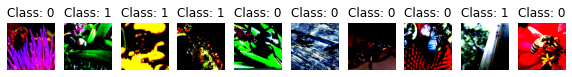

In [ ]:
''' 5. 데이터 확인하기 (2) '''
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(np.transpose(X_train[i], (1, 2, 0)))
    plt.title('Class: ' + str(y_train[i].item()))

In [ ]:
''' 6. 불러온 특정 모델에 대하여 학습을 진행하며 학습 데이터에 대한 모델 성능을 확인하는 함수 정의 '''
def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, batch_idx * len(image), 
                len(train_loader.dataset), 100. * batch_idx / len(train_loader), 
                loss.item()))

In [ ]:
''' 7. 학습되는 과정 속에서 검증 데이터에 대한 모델 성능을 확인하는 함수 정의 '''
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
    
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

- 개미 & 벌 클래스 2개이기 때문에 Fully connected layer output 노드 수 2개로 설정
  - 1개로 설정 후 `nn.BCEWithLogitsLoss()`로도 학습 가능. 단, 차원을 맞춰주어야 하고 label의 type을 float로 변경해주어야 함

In [ ]:
''' 8. PyTorch 내에서 제공하는 미리 학습되지 않은 ResNet18 모델 불러온 후 Output 크기 설정하기 '''
import torchvision.models as models

model = models.resnet18(pretrained = False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model = model.cuda() 

In [ ]:
''' 9. Optimizer, Objective Function 설정하기 '''
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

- 미리 학습되지 않은 ResNet18 학습 시 60% 내외의 분류 성능을 확인할 수 있음

In [ ]:
''' 10. 미리 학습되지 않은 ResNet18 학습 실행하며 Train, Test set의 Loss 및 Test set Accuracy 확인하기 '''
for epoch in range(1, EPOCHS + 1):
    train(model, dataloaders["train"], optimizer, log_interval = 5)
    test_loss, test_accuracy = evaluate(model, dataloaders["val"])
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Train Epoch: 1 [0/397 (0%)]	Train Loss: 0.704001
Train Epoch: 1 [160/397 (38%)]	Train Loss: 1.005134
Train Epoch: 1 [320/397 (77%)]	Train Loss: 0.627280

[EPOCH: 1], 	Test Loss: 0.2305, 	Test Accuracy: 59.19 % 

Train Epoch: 2 [0/397 (0%)]	Train Loss: 0.953060
Train Epoch: 2 [160/397 (38%)]	Train Loss: 0.733213
Train Epoch: 2 [320/397 (77%)]	Train Loss: 0.785344

[EPOCH: 2], 	Test Loss: 0.0616, 	Test Accuracy: 52.39 % 

Train Epoch: 3 [0/397 (0%)]	Train Loss: 0.721970
Train Epoch: 3 [160/397 (38%)]	Train Loss: 0.816668
Train Epoch: 3 [320/397 (77%)]	Train Loss: 0.673244

[EPOCH: 3], 	Test Loss: 0.0220, 	Test Accuracy: 61.96 % 

Train Epoch: 4 [0/397 (0%)]	Train Loss: 0.650641
Train Epoch: 4 [160/397 (38%)]	Train Loss: 0.651655
Train Epoch: 4 [320/397 (77%)]	Train Loss: 0.653502

[EPOCH: 4], 	Test Loss: 0.0216, 	Test Accuracy: 63.73 % 

Train Epoch: 5 [0/397 (0%)]	Train Loss: 0.679331
Train Epoch: 5 [160/397 (38%)]	Train Loss: 0.618197
Train Epoch: 5 [320/397 (77%)]	Train Loss: 0.625293

- Fine-tuning 시 90% 이상의 분류성능을 확인할 수 있음

In [ ]:
''' 11. IMAGENET 데이터로 미리 학습이 된 ResNet18 모델을 불러온 후 개미, 벌 이미지 데이터에 맞게 Fine Tuning 해보기 '''
model = models.resnet18(pretrained = True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model = model.cuda()

optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)  # pretrained = True 로 하면 learning - rate를 작게 해주는 것이 좋다. 
EPOCHS = 10                                                    # 왜냐하면 pretrained 가 true라는 것은 전이학습을 시켜준 모델이기 때문에 이제는 세세하게 찾는 것이 좋다는 것.
for epoch in range(1, EPOCHS + 1):                             # random search 했으니 이제는 grid search를 하자는 느낌이랑 비슷 
    train(model, dataloaders["train"], optimizer, log_interval = 5)
    valid_loss, valid_accuracy = evaluate(model, dataloaders["val"])
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, valid_loss, valid_accuracy))

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Train Epoch: 1 [0/397 (0%)]	Train Loss: 0.674654
Train Epoch: 1 [160/397 (38%)]	Train Loss: 0.759197
Train Epoch: 1 [320/397 (77%)]	Train Loss: 0.683529

[EPOCH: 1], 	Test Loss: 0.0201, 	Test Accuracy: 66.25 % 

Train Epoch: 2 [0/397 (0%)]	Train Loss: 0.782187
Train Epoch: 2 [160/397 (38%)]	Train Loss: 0.499478
Train Epoch: 2 [320/397 (77%)]	Train Loss: 0.480971

[EPOCH: 2], 	Test Loss: 0.0180, 	Test Accuracy: 72.54 % 

Train Epoch: 3 [0/397 (0%)]	Train Loss: 0.439787
Train Epoch: 3 [160/397 (38%)]	Train Loss: 0.555764
Train Epoch: 3 [320/397 (77%)]	Train Loss: 0.406821

[EPOCH: 3], 	Test Loss: 0.0145, 	Test Accuracy: 83.12 % 

Train Epoch: 4 [0/397 (0%)]	Train Loss: 0.433266
Train Epoch: 4 [160/397 (38%)]	Train Loss: 0.350489
Train Epoch: 4 [320/397 (77%)]	Train Loss: 0.381771

[EPOCH: 4], 	Test Loss: 0.0124, 	Test Accuracy: 86.40 % 

Train Epoch: 5 [0/397 (0%)]	Train Loss: 0.356355
Train Epoch: 5 [160/397 (38%)]	Train Loss: 0.345936
Train Epoch: 5 [320/397 (77%)]	Train Loss: 0.338145